In [55]:
import pandas as pd
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder # Label encoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer()
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn import model_selection
# from scipy.stats import zscore

from sklearn.model_selection import KFold
from imblearn.pipeline import pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectFromModel


labelencoder = LabelEncoder()


In [56]:
fund_config = pd.read_csv('fund_config.csv')
fund_ratios = pd.read_csv('fund_ratios.csv', thousands=',')
bond_ratings = pd.read_csv('bond_ratings.csv', thousands=',')
fund_allocations = pd.read_csv('fund_allocations.csv', thousands=',') # ID
fund_specs = pd.read_csv('fund_specs.csv', thousands=',')
other_specs = pd.read_csv('other_specs.csv', thousands=',')
return_3year = pd.read_csv('return_3year.csv', thousands=',')
return_5year = pd.read_csv('return_5year.csv', thousands=',')
return_10year = pd.read_csv('return_10year.csv', thousands=',')
fund_allocations.rename(columns={'id': 'tag'}, inplace=True)

data = fund_config.merge(fund_ratios, on='fund_id' )
data = data.merge(bond_ratings, on='tag')
data = data.merge(fund_allocations, on='tag')
data = data.merge(fund_specs, on='tag')
data = data.merge(other_specs, on='tag')
data = data.merge(return_3year, on='tag')
data = data.merge(return_5year, on='tag')
data = data.merge(return_10year, on='fund_id')

data['greatstone_rating'] = data.apply(
    lambda row: row['greatstone_rating_y'],
    axis=1
)

data.drop(['greatstone_rating_x', 'greatstone_rating_y', 'tag'], axis=1, inplace=True)

test_data = pd.DataFrame(data[data['greatstone_rating'].isnull()])

data.drop(data[data['greatstone_rating'].isnull()].index.tolist(), inplace=True, axis=0)

data.greatstone_rating.replace({0: 1}, inplace=True)

data = data.reset_index(drop=True)

# # dropping rows which has more than 50 null value
# null_values_indexs = []
# for i in range(len(data.index)) :
#     if data.iloc[i].isnull().sum() > 30 :
#         # print("Nan in row ", i , " : " ,  data.iloc[i].isnull().sum())
#         null_values_indexs.append(i)
        
# print(f'\nDroping rows: {len(null_values_indexs)}')
# print(f'\nDroping rows: {null_values_indexs}')
# data.drop(null_values_indexs, inplace=True)

In [57]:
# missing_df = data.isnull().sum(axis=0).reset_index()
# missing_df.columns = ['column_name', 'missing_count']
# missing_df = missing_df.loc[missing_df['missing_count']>0]
# missing_df = missing_df.sort_values(by='missing_count')

# ind = np.arange(missing_df.shape[0])
# width = 0.9
# fig, ax = plt.subplots(figsize=(12,30))
# rects = ax.barh(ind, missing_df.missing_count.values, color='blue')
# ax.set_yticks(ind)
# ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
# ax.set_xlabel("Count of missing values")
# ax.set_title("Number of missing values in each column")
# plt.show()

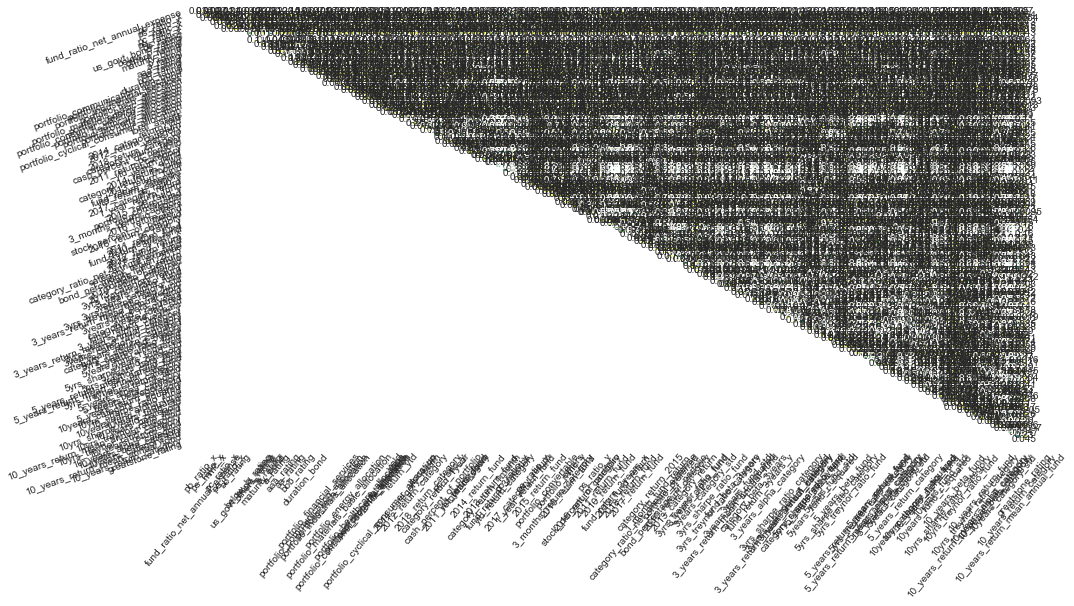

We can drop ['pc_ratio_y', 'ytd_return_fund', 'fund_return_3months', 'pb_ratio_y', 'pe_ratio_y', '3_months_return_category', 'mmc_y', 'ps_ratio_y', '3_years_return_mean_annual_fund', 'fund_return_3years_y', 'category_r_squared_5years', '5years_fund_r_squared', '5years_fund_std', '5_years_beta_fund', '5_years_return_fund', '5years_category_std', '10years_fund_std', '10years_category_std', '10_years_return_mean_annual_fund'] 

We will drop ['pc_ratio_y', 'ytd_return_fund', 'fund_return_3months', 'pb_ratio_y', 'pe_ratio_y', '3_months_return_category', 'mmc_y', 'ps_ratio_y', 'category_r_squared_5years', '5years_fund_std', '5_years_beta_fund', '10years_fund_std', '10years_category_std'] 



In [58]:
# Create correlation matrix
corr_matrix = data.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

mask = upper == 0  # to mask the upper triangle in the following heatmap

plt.figure(figsize = (15,8))  # setting the figure size
sns.set_style(style = 'white')  # Setting it to white so that we do not see the grid lines
g = sns.heatmap(upper, center=0.5, cmap= 'summer_r', annot= True, xticklabels = corr_matrix.index, 
                yticklabels = corr_matrix.columns, cbar= False, linewidths= 1, mask = mask)   # Da Heatmap
g.set_yticklabels(g.get_yticklabels(), rotation=0, horizontalalignment='right')
bottom, top = g.get_ylim()
g.set_ylim(bottom + 0.5, top - 0.5)
plt.xticks(rotation = 50)   # Aesthetic purposes
plt.yticks(rotation = 20)   # Aesthetic purposes
plt.show()

# Find index of feature columns with correlation greater than 0.95
corr_to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]


remove_list = ['pc_ratio_y', 'ytd_return_fund', 'fund_return_3months', 'pb_ratio_y', 'pe_ratio_y', '3_months_return_category', 'mmc_y', 'ps_ratio_y', 'category_r_squared_5years', '5years_fund_std', '5_years_beta_fund', '10years_fund_std', '10years_category_std']

print(f'We can drop {corr_to_drop} \n')

print(f'We will drop {remove_list} \n')

In [59]:
categorical_features = data.select_dtypes(include=['object']).columns
categorical_features

Index(['category', 'parent_company', 'fund_id', 'fund_name',
       'investment_class', 'currency', 'inception_date', 'fund_size'],
      dtype='object')

In [60]:
# data.drop(['category', 'parent_company', 'fund_id', 'fund_name', 'currency', 'inception_date'], axis=1, inplace=True)

cols_to_drop = ['parent_company', 'fund_id', 'fund_name', 'currency', 'inception_date'] + remove_list


In [61]:
print(f'Columns to drop {cols_to_drop} ')

Columns to drop ['parent_company', 'fund_id', 'fund_name', 'currency', 'inception_date', 'pc_ratio_y', 'ytd_return_fund', 'fund_return_3months', 'pb_ratio_y', 'pe_ratio_y', '3_months_return_category', 'mmc_y', 'ps_ratio_y', 'category_r_squared_5years', '5years_fund_std', '5_years_beta_fund', '10years_fund_std', '10years_category_std'] 


In [62]:
# outliers_handling
def outliers_handling(cols):
    cols = pd.DataFrame(cols)
    Q1 = cols.quantile(0.25)
    Q3 = cols.quantile(0.75)
    IQR = Q3 - Q1
    # print(IQR)

    # Replace every outlier on the lower side by the lower whisker
    for i, j in zip(np.where(cols < Q1 - 1.5 * IQR)[0], np.where(cols < Q1 - 1.5 * IQR)[1]): 

        whisker  = Q1 - 1.5 * IQR
        cols.iloc[i,j] = whisker[j]


    #Replace every outlier on the upper side by the upper whisker    
    for i, j in zip(np.where(cols > Q3 + 1.5 * IQR)[0], np.where(cols > Q3 + 1.5 * IQR)[1]):

        whisker  = Q3 + 1.5 * IQR
        cols.iloc[i,j] = whisker[j]
        
    return cols

data.total_assets = outliers_handling(data.total_assets)

In [63]:
# data.drop()

X = data.drop('greatstone_rating', axis=1)
y = data.greatstone_rating
y = label_binarizer.fit_transform(y)

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = data.select_dtypes(include=['object']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('drop_columns', 'drop', cols_to_drop),
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [64]:
rfc= RandomForestClassifier(n_estimators = 200, random_state=1, max_depth=30, criterion='entropy', class_weight='balanced') 
#max_leaf_nodes=30

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
# https://scikit-learn.org/stable/modules/feature_selection.html
clf = Pipeline(steps=[
                        ('preprocessor', preprocessor),
                        ('feature_selection', SelectFromModel(RandomForestClassifier(), threshold=0.003 )),
                        ('classifier', rfc)
                    ])

# clf = Pipeline(steps=[('preprocessor', preprocessor),
#                       ('classifier', rfc)])

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

In [66]:
kfold = KFold(n_splits=10, random_state=1, shuffle=True )

rfcl_cross_val_score = model_selection.cross_val_score(clf, X_train, y_train, cv=kfold, scoring='average_precision')

print(rfcl_cross_val_score)

print(rfcl_cross_val_score.mean())

print(rfcl_cross_val_score.std())

[0.86084438 0.86818868 0.84529856 0.86406059 0.86554974 0.87424183
 0.87317796 0.84558645 0.8655381  0.86235417]
0.8624840463544959
0.009433632613861811


In [67]:
clf.fit(X_train, y_train)

print("Train data model score: %.3f" % clf.score(X_train, y_train))
print("Test data model score: %.3f" % clf.score(X_test, y_test))

Train data model score: 1.000
Test data model score: 0.702


In [68]:
y_pred = clf.predict(X_test)
print("model score: %.3f" % metrics.precision_score(y_test, y_pred, average='micro'))

model score: 0.837


In [69]:
print(label_binarizer.inverse_transform(y_test))
print(label_binarizer.inverse_transform(y_pred))

[1. 3. 1. ... 3. 3. 5.]
[1. 3. 1. ... 3. 1. 5.]


In [70]:
fund_ids = test_data.fund_id
test_data_copy = test_data.copy()
test_data.drop(['greatstone_rating'], axis=1, inplace=True)

In [71]:
y_test_data_pred = clf.predict(test_data)
y_test_data_pred

array([[0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       ...,
       [0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0]])

In [72]:
predicted = label_binarizer.inverse_transform(y_test_data_pred)

In [73]:
submission = pd.DataFrame({'fund_id': fund_ids, 'greatstone_rating': predicted})

submission

,fund_id,greatstone_rating
0,264614c6-5ac3-4146-ba26-1674b136cb40,2.0
7,08702e4f-c5bb-4f0a-b63b-f9e4a0eb2425,1.0
16,cf56db43-046b-49d0-b8f0-90fe9cf8aacf,2.0
24,3faa81fc-9640-43d0-8b68-e5b06c65bfe6,3.0
28,09e24f3d-7191-4207-887c-98f31c6b59d2,3.0
...,...,...
24983,fc278788-24bf-4844-a538-d8c67d47275c,3.0
24992,0a3c101f-c969-4e85-8395-3dc3e33dd3d6,4.0
24996,12fc8949-6563-4dd4-a7cc-0400131fa6ab,3.0
24998,65421547-1407-4c50-92dc-e1cb1e9972dd,2.0


In [74]:
submission.to_csv('submission_file.csv', index=False)

In [75]:
sub = pd.read_csv('sample_submission.csv')

In [ ]:
newdf = pd.DataFrame()
for i in range(len(sub)) :
    fund_id = sub.loc[i, "fund_id"]
    greatstone_rating = submission.loc[submission[submission['fund_id'] == fund_id].index.to_list()[0], "greatstone_rating"]
#     print(fund_id)
#     print(submission[submission['fund_id'] == fund_id].index.to_list())
#     greatstone_rating = submission[submission['fund_id'] == fund_id]["greatstone_rating"]
#     print(fund_id, submission[submission['fund_id'] == fund_id]["greatstone_rating"])
    newdf = newdf.append({'fund_id': fund_id, 'greatstone_rating': greatstone_rating}, ignore_index=True)
# #     modDfObj = dfObj.append(pd.Series(['Raju', 21, 'Bangalore', 'India'], index=dfObj.columns ), ignore_index=True)
    

In [ ]:
newdf

In [ ]:
newdf.to_csv('submission_file.csv', index=False)